In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt
import time

import optax

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.variational.vi import VIEngine
from mcjax.proba.neal_funnel import NealFunnel

from mcjax.proba.gauss import GaussianDiag, GaussianFullCov, GaussianDiagMixture, GaussianFullMixture
from mcjax.util.plot_2d import evaluate_on_grid_2d, create_ellipse



In [2]:
# initialize PRNG
key = jr.key(0)

In [3]:
dist = NealFunnel()
logdensity = dist.logdensity
logdensity_batch = jax.vmap(logdensity)

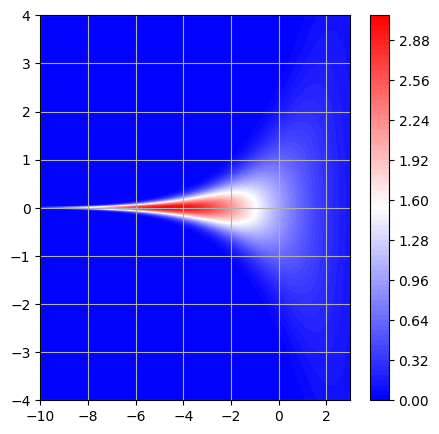

In [14]:
xmin, xmax = -10, 3
ymin, ymax = -4, 4
X, Y, Z = evaluate_on_grid_2d(
    func_batch=logdensity_batch,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    Nx=500,
    Ny=500
)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.grid()


In [5]:
approx_diag, params_diag = GaussianDiag.create(dim=2)  # returns a Distribution instance
engine_diag = VIEngine.create(approx=approx_diag)

approx_full, params_full = GaussianFullCov.create(dim=2)
engine_full = VIEngine.create(approx=approx_full)

key, key_ = jr.split(key)
num_components_mix = 15
approx_mix, params_mix = GaussianDiagMixture.create(dim=2, num_components=num_components_mix, key=key_)
engine_diag_mix = VIEngine.create(approx=approx_mix)

key, key_ = jr.split(key)
num_components_mix_full = 15
approx_mix_full, params_mix_full = GaussianFullMixture.create(dim=2, num_components=num_components_mix_full, key=key_)
engine_diag_mix_full = VIEngine.create(approx=approx_mix_full)


approx_name_list = ['diag', 'full', 'mix', 'mix_full']
approx_list = [approx_diag, approx_full, approx_mix, approx_mix_full]
params_init_list = [params_diag, params_full, params_mix, params_mix_full]
engine_list = [engine_diag, engine_full, engine_diag_mix, engine_diag_mix_full]

In [9]:
optimizer = optax.adam(learning_rate=1e-2)

In [10]:
n_samples = 100
n_iter = 10_000
vi_output_dict = {}

for approx_name, params_init, engine in zip(approx_name_list, params_init_list, engine_list):
    print(f'Running {approx_name} approximation')
    params = params_init


    start_time = time.time()
    results = engine.run(
        params_init=params,
        log_prob=logdensity,
        key=key,
        optimizer=optimizer,
        n_samples=n_samples,
        n_iter=n_iter,
        verbose=False,
    )
    end_time = time.time()
    final_kl = results["kl_trace"][-1]
    print(f'\t Elapsed time: {end_time - start_time:.2f} seconds \t Final KL: {final_kl:.4f}')
    
    vi_output_dict[approx_name] = results
    

Running diag approximation
	 Elapsed time: 2.28 seconds 	 Final KL: -2.0974
Running full approximation
	 Elapsed time: 2.39 seconds 	 Final KL: -2.0985
Running mix approximation
	 Elapsed time: 8.97 seconds 	 Final KL: -2.9236
Running mix_full approximation
	 Elapsed time: 11.72 seconds 	 Final KL: -2.9034


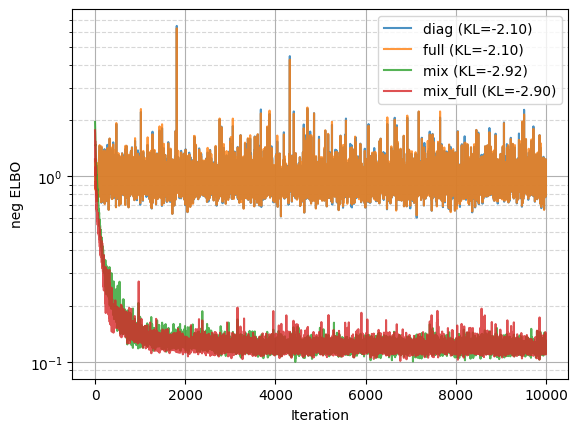

In [11]:
# compute the minimum of all negElbo for plotting
kl_all = jnp.concatenate([vi_output_dict[approx_name]["kl_trace"] for approx_name in approx_name_list], axis=0)
kl_min = jnp.min(kl_all)-0.1

# plot the results
for approx_name in approx_name_list:
    plt.plot(
        vi_output_dict[approx_name]["kl_trace"] - kl_min,
        label=f'{approx_name} (KL={vi_output_dict[approx_name]["kl_trace"][-1]:.2f})',
        alpha=0.8,
    )
plt.yscale('log')

# add label and legend
plt.xlabel('Iteration')
plt.ylabel('neg ELBO')
plt.grid(which="major", linestyle='-')
plt.grid(which="minor", linestyle='--', alpha=0.5)

# add legend upper right
plt.legend(loc='upper right')

In [12]:
vi_output_dict["mix"]["params"]["components"][0]

{'mu': Array([5.036502  , 0.04377541], dtype=float32),
 'std': Array([ 0.6163857, 11.714478 ], dtype=float32)}

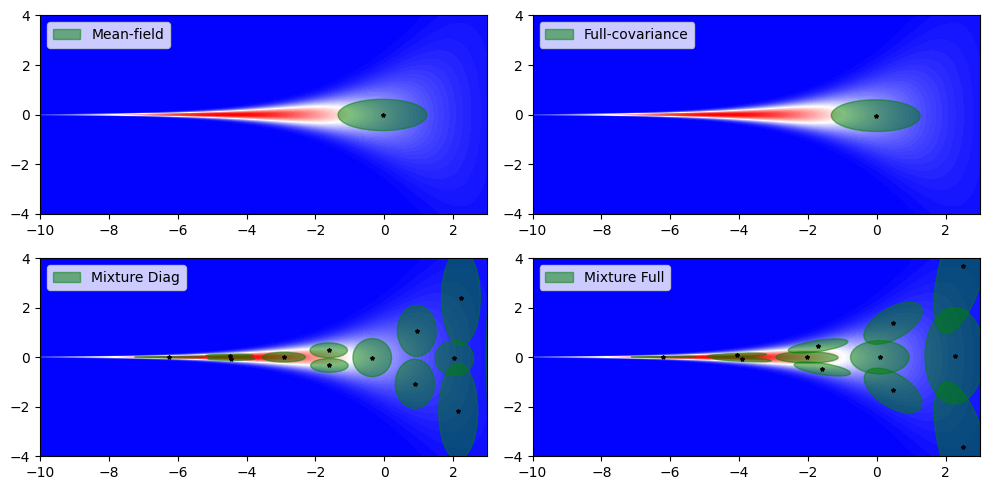

In [21]:
import matplotlib.pyplot as plt

# Create side-by-side plots
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

########################
# Mean-field plot
########################
ax = axes[0,0]
# Extract final mean-field (diag) parameters
mu_diag = vi_output_dict["diag"]["params"]["mu"]
std_diag = vi_output_dict["diag"]["params"]["std"]
cov_diag = jnp.diag(std_diag ** 2)

# Add Ellipse
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.add_artist(create_ellipse(mu_diag, cov_diag, color='green', label='Mean-field'))
ax.plot(mu_diag[0], mu_diag[1], marker='*', color='black', markersize=3)
ax.legend(loc="upper left")

################
# Full covariance plot
################
ax = axes[0,1]
# Extract final full covariance parameters
mu_full = vi_output_dict["full"]["params"]["mu"]
cov_full = vi_output_dict["full"]["params"]["cov"]

ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.add_artist(create_ellipse(mu_full, cov_full, color='green', alpha=0.5, label='Full-covariance'))
ax.plot(mu_full[0], mu_full[1], marker='*', color='black', markersize=3)
ax.legend(loc="upper left")

################
# mixture diagonal
################
ax = axes[1,0]
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')

for k in range(num_components_mix):
    mu = vi_output_dict["mix"]["params"]["components"][k]["mu"]
    std = vi_output_dict["mix"]["params"]["components"][k]["std"]
    # mu = mus[k]
    # std = stds[k]
    cov = jnp.diag(std ** 2)
    if k==0:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.5, label='Mixture Diag'))
    else:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.5))
    ax.plot(mu[0], mu[1], marker='*', color='black', markersize=3)
# set the axis limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(loc="upper left")
plt.tight_layout()

# ################
# # mixture full
# ################
ax = axes[1,1]

ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')

for k in range(num_components_mix_full):
    mu = vi_output_dict["mix_full"]["params"]["components"][k]["mu"]
    cov = vi_output_dict["mix_full"]["params"]["components"][k]["cov"]
    if k==0:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.5, label='Mixture Full'))
    else:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.5))
    ax.plot(mu[0], mu[1], marker='*', color='black', markersize=3)
# set the axis limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(loc="upper left")
plt.tight_layout()

### Generate samples from the variational family

In [18]:
n_samples = 10_000
key, key_ = jr.split(key)

params_mix = vi_output_dict["mix"]["params_raw"]
samples_mix = approx_mix.sample(
    params=params_mix,
    key=key_,
    n_samples=n_samples
)

params_mix_full = vi_output_dict["mix_full"]["params_raw"]
samples_mix_full = approx_mix_full.sample(
    params=params_mix_full,
    key=key_,
    n_samples=n_samples
)

Text(0.5, 1.0, 'Mixture of full Gaussians samples')

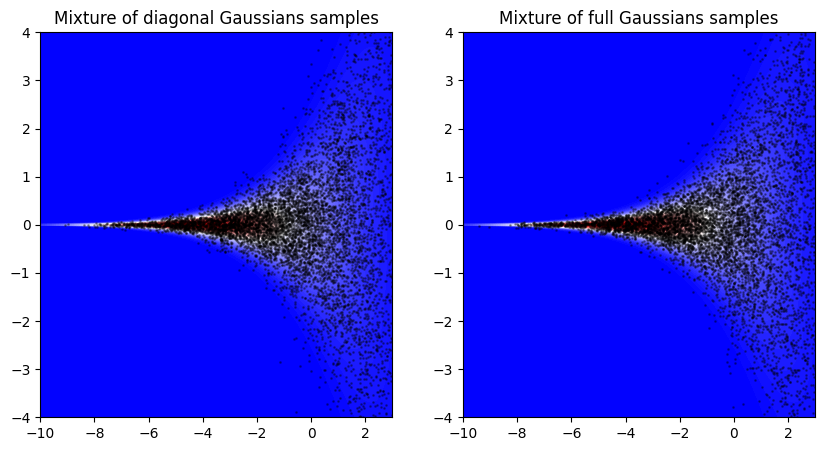

In [23]:
# plot the density
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# mixture of diagonal Gaussians
ax = axes[0]
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.scatter(samples_mix[:, 0], samples_mix[:, 1], s=1, color='black', alpha=0.3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title('Mixture of diagonal Gaussians samples')

# mixture of full Gaussians
ax = axes[1]
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.scatter(samples_mix_full[:, 0], samples_mix_full[:, 1], s=1, color='black', alpha=0.3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title('Mixture of full Gaussians samples')



Text(0, 0.5, 'Quantiles of N(0, 3^2)')

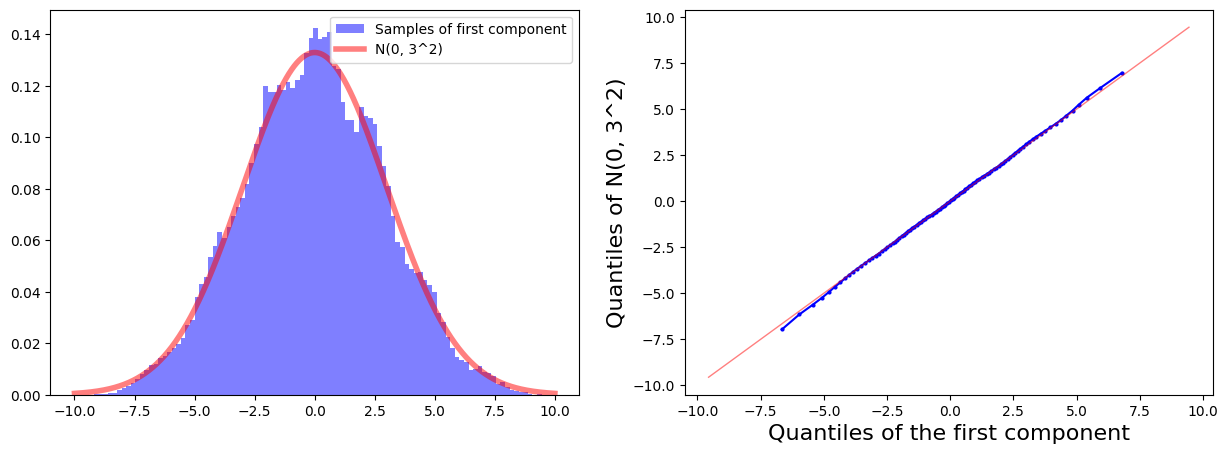

In [56]:
# the first marginal of the Neal funnel is N(0, 3^2)
# so let's do some testing

# generate samples
n_samples = 100_000
samples = approx_mix_full.sample(
    params=params_mix_full,
    key=key_,
    n_samples=n_samples)

# samples = approx_mix.sample(
#     params=params_mix,
#     key=key_,
#     n_samples=n_samples)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

### left panel: draw histogram of the first component
ax = axes[0]
_ = ax.hist(samples[:, 0], bins=100, density=True, alpha=0.5, color='blue', label='Samples of first component')
# superpose pdf of a centred gaussian with std=3
x = jnp.linspace(-10, 10, 1000)
pdf = jax.scipy.stats.norm.pdf(x, loc=0, scale=3)
ax.plot(x, pdf, color='red', label='N(0, 3^2)', lw=4, alpha=0.5)
ax.legend(loc='upper right', fontsize=10)

### right panel: compare the quantiles of the first component
ax = axes[1]
# compute the quantiles of the first component
n_quantiles = 100
quantiles = jnp.quantile(samples[:, 0], jnp.linspace(0, 1, n_quantiles))
# compute the quantiles of a centred gaussian with std=3
quantiles_gauss = jax.scipy.stats.norm.ppf(jnp.linspace(0, 1, n_quantiles), loc=0, scale=3)
ax.plot(quantiles, quantiles_gauss, marker='o', markersize=2, color='blue', label='Quantiles')
# add the diagonal line
ax.plot(quantiles, quantiles, color='red', lw=1, label='y=x', alpha=0.5)
# add labels
ax.set_xlabel('Quantiles of the first component', fontsize=16)
ax.set_ylabel('Quantiles of N(0, 3^2)', fontsize=16)

